## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Oriyomi Raheem, Ali Eghbali, Michael Pyrcz, Carlos Torres-Verdin
***

In [ ]:
from main import *
ari = ARI()
case1, case2 = ari.load_data()

### Case 1

In [ ]:
case1_qinv = ari.quadratic_inversion(case1)

In [ ]:
inv1 = ari.resistivity_inversion(case1, x0=[0.5,1.45], Rvsh=2.813, Rhsh=0.775, 
                                 Wd_matrix=True, tolerance=1e-10, maxiter=1e5, 
                                 lambda_reg=1e-8, method='CG', bounds=None)

ari.plot_inversion_results(inv1, figsize=(20,12))

In [ ]:
inv1 = ari.resistivity_inversion(case1, x0=[0.5, 1.45], Rvsh=2.813, Rhsh=0.775,
                                 Wd_matrix=True, tolerance=1e-10, maxiter=1e5,
                                 lambda_reg=1e-8, method='L-BFGS-B', bounds=[(0,1),(None,None)])

ari.plot_inversion_results(inv1, figsize=(20,12))

### Case 2

In [ ]:
case2_qinv = ari.quadratic_inversion(case2)

In [ ]:
inv2 = ari.resistivity_inversion(case2, x0=[0.5,1.45], Rvsh=4.043, Rhsh=0.674,
                                 Wd_matrix=True, tolerance=1e-10, maxiter=1e5, 
                                 lambda_reg=1e-8, method='CG', bounds=None)

ari.plot_inversion_results(inv2, figsize=(20,12))

In [ ]:
inv2 = ari.resistivity_inversion(case2, x0=[0.5,1.45], Rvsh=4.043, Rhsh=0.674, 
                                 Wd_matrix=True, tolerance=1e-8, maxiter=1e5, 
                                 lambda_reg=1e-8, method='L-BFGS-B', bounds=[(0,1),(None,None)])

ari.plot_inversion_results(inv2, figsize=(20,12))

***
# Physics-Informed Artificial Neural Network
***

In [91]:
from main import *
ari = ARI()
case1, case2 = ari.load_data()


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.2.2+cu121 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------



In [92]:
def plot_pinn_results(df, figsize=(15,10), subtitle:str=None):
    fig, axs = plt.subplots(1, 4, figsize=figsize, sharey=True)
    ax1, ax2, ax3, ax4 = axs

    ax11 = ax1.twiny()
    ari.plot_curve(ax1, df, 'GR', 0, 150, 'g', units='API', pad=8)
    ari.plot_curve(ax11, df, 'Csh_pred', 0, 1, 'k', units='v/v')

    ax21, ax22 = ax2.twiny(), ax2.twiny()
    ari.plot_curve(ax2, df, 'AT10', 0.2, 50, 'r', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax21, df, 'AT90', 0.2, 50, 'b', semilog=True, units='$\Omega\cdot m$', pad=16)
    ari.plot_curve(ax22, df, 'Rss_pred', 0.2, 50, 'k', units='$\Omega\cdot m$', semilog=True)

    ax31, ax32 = ax3.twiny(), ax3.twiny()
    ari.plot_curve(ax31, df, 'Rv', 0.2, 100, 'r', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax32, df, 'Rv_sim', 0.2, 100, 'k', units='$\Omega\cdot m$', semilog=True)
    ari.plot_curve(ax3, df, 'Rv_err', 0, 100, 'darkred', alpha=0.5, units='%', pad=16)

    ax41, ax42 = ax4.twiny(), ax4.twiny()
    ari.plot_curve(ax41, df, 'Rh', 0.2, 100, 'b', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax42, df, 'Rh_sim', 0.2, 100, 'k', units='$\Omega\cdot m$', semilog=True)
    ari.plot_curve(ax4, df, 'Rh_err', 0, 100, 'darkblue', alpha=0.5, units='%', pad=16)

    [ax.grid(True, which='both') for ax in axs]
    ax1.invert_yaxis()
    if subtitle is None:
        title = 'PINN Inversion Results'
    else:
        title = 'PINN Inversion Results | {}'.format(subtitle)
    fig.suptitle(title, weight='bold')
    plt.tight_layout()
    plt.show()

def plot_pinn_crossplot(res_aniso, sim, vlims=[0.05,100], hlims=[0.2,10], alpha=0.6, figsize=(12,5)):
    Rv_sim, Rh_sim = sim
    fig, axs = plt.subplots(1, 3, figsize=figsize, width_ratios=[1,1,0.05])
    ax1, ax2, ax3 = axs
    im = ax1.scatter(res_aniso['Rv'], Rv_sim, marker='o', alpha=alpha, 
                 c=res_aniso.index, cmap='jet', edgecolor='gray')
    ax1.set(xlabel='Rv (measured) [$\Omega\cdot m$]', ylabel='Rv (simulated) [$\Omega\cdot m$]',
            xlim=vlims, ylim=vlims, xscale='log', yscale='log')
    ax1.plot(vlims, vlims, 'k--')
    im = ax2.scatter(res_aniso['Rh'], Rh_sim, marker='o', alpha=alpha, 
                    c=res_aniso.index, cmap='jet', edgecolor='gray')
    ax2.set(xlabel='Rh (measured) [$\Omega\cdot m$]', ylabel='Rh (simulated) [$\Omega\cdot m$]',
            xlim=hlims, ylim=hlims, xscale='log', yscale='log')
    ax2.plot(hlims, hlims, 'k--')
    cb=fig.colorbar(im, cax=ax3, label='Depth [ft]')
    for ax in axs:
        ax.grid(True, which='both')
    plt.tight_layout()
    plt.show()

def plot_loss(epochs, losses, figsize=(5,3)):
    train_loss, valid_loss = losses
    plt.figure(figsize=figsize)
    plt.plot(range(epochs), train_loss, label='Trianing', c='tab:blue')
    plt.plot(range(epochs), valid_loss, label='Validation', c='tab:orange')
    plt.legend(facecolor='lightgrey', edgecolor='k')
    plt.grid(True, which='both')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.xlim(-2, epochs+2)
    plt.tight_layout()
    plt.show()

In [ ]:
class LSTMari(nn.Module):
    def __init__(self):
        super(LSTMari, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.rn1 = nn.LSTM(input_size=64,  hidden_size=128, num_layers=2, batch_first=True, dropout=0.1)
        self.rn2 = nn.LSTM(input_size=128, hidden_size=64,  num_layers=2, batch_first=True, dropout=0.1)
        self.fc3 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x, _ = self.rn1(x)
        x = nn.ReLU()(x)
        x, _ = self.rn2(x)
        x = nn.ReLU()(self.fc3(x))
        return x
    
class siameseFNO(nn.Module):
    def __init__(self, Csh_constraint:bool=False):
        super(siameseFNO, self).__init__()
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(2,   64,  kernel_size=3, padding=1),
            nn.Conv1d(64,  256, kernel_size=3, padding=1),
            nn.Conv1d(256, 64,  kernel_size=3, padding=1),
        ])      
        self.output_layer = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.Csh_constraint = Csh_constraint

    def complex_relu(self, x):
        return torch.complex(torch.relu(x.real), torch.relu(x.imag))
        
    def forward(self, x):
        x = x.to(torch.complex64).permute(1,0)
        x_freq = torch.fft.fft(torch.fft.fftshift(x), dim=-2)
        for layer in self.conv_layers:
            layer.weight = nn.Parameter(layer.weight.to(torch.complex64))
            layer.bias = nn.Parameter(layer.bias.to(torch.complex64))
            x_freq = self.complex_relu(layer(x_freq))
        x_out = torch.fft.ifft(torch.fft.ifftshift(x_freq), dim=-2)
        x_out = self.output_layer(torch.abs(x_out))
        x_out = x_out.permute(1,0)
        return x_out

In [ ]:
class siameseNN(nn.Module):
    def __init__(self):
        super(siameseNN, self).__init__()
        self.fc1 = nn.Linear(3, 16)
        self.fc2 = nn.Linear(16, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [ ]:
class PhysicsInformedLoss(torch.nn.Module):
    def __init__(self, lambda_reg=1e-5, Rvsh=2.813, Rhsh=0.775):
        super(PhysicsInformedLoss, self).__init__()
        self.lambda_reg = lambda_reg
        self.Rvsh = Rvsh
        self.Rhsh = Rhsh

    def forward(self, inputs, outputs):
        Rv_true = inputs[:, 0]
        Rh_true = inputs[:, 1]
        gr_true = inputs[:, 2]
        
        Csh = outputs[:, 0]
        Rss = outputs[:, 1]
    
        eq1 = (Csh*self.Rvsh + (1-Csh)*Rss) - (Rv_true)
        eq2 = 1/(Csh/self.Rhsh + (1-Csh)/Rss) - (Rh_true)
        eqs = torch.stack([eq1, eq2], dim=-1)

        wd1, wd2 = 1/Rv_true/gr_true, 1*Rh_true/gr_true
        Wdm = torch.stack([wd1, wd2], dim=-1)

        cost = torch.matmul(Wdm.T, eqs)
        return torch.norm(cost, p=2) + self.lambda_reg*torch.norm(inputs, p=2)

In [ ]:
d = lasio.read('well1.las').df()[['CALI', 'AT10','AT30','AT60','AT90','GR','RV72H_1D_FLT','RH72H_1D_FLT']].dropna()
column_names = ['CALI', 'AT10', 'AT30', 'AT60', 'AT90', 'GR', 'Rv', 'Rh']

zstart = int(np.argwhere(d.index==9720).squeeze())
zend   = int(np.argwhere(d.index==10110).squeeze())
data = d.rename(columns=dict(zip(d.columns, column_names))).iloc[zstart:zend]
res_aniso  = data[['Rv','Rh','GR']]

Rvsh=2.813
Rhsh=0.775

inputs         = torch.tensor(res_aniso.values, dtype=torch.float32)
dataset        = TensorDataset(inputs)
train_percent  = 0.8
xtrain, xvalid = random_split(dataset, [int(train_percent*len(dataset)), len(dataset)-int(train_percent*len(dataset))])
trainloader    = DataLoader(xtrain, batch_size=100, shuffle=True)
validloader    = DataLoader(xvalid, batch_size=100, shuffle=True)

csh_model  = siameseNN()
rss_model  = siameseNN()
criterion  = PhysicsInformedLoss(Rvsh=Rvsh, Rhsh=Rhsh)
optimizer  = torch.optim.Adam([{'params': csh_model.parameters()}, 
                               {'params': rss_model.parameters()}], lr=1e-3)

epochs = 251
train_loss, valid_loss = [], []
for epoch in range(epochs):
    # training
    epoch_train_loss = []
    csh_model.train()
    rss_model.train()
    for batch in trainloader:
        optimizer.zero_grad()
        x = batch[0]
        y = torch.cat((csh_model(x), rss_model(x)), dim=1)
        loss = criterion(x, y)
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())
    train_loss.append(np.mean(epoch_train_loss))
    # validation
    csh_model.eval()
    rss_model.eval()
    epoch_valid_loss = []
    with torch.no_grad():
        x = next(iter(validloader))[0]
        y = torch.cat((csh_model(x), rss_model(x)), dim=1)
        loss = criterion(x, y)
        epoch_valid_loss.append(loss.item())
    valid_loss.append(np.mean(epoch_valid_loss))
    # progress
    if epoch % 50 == 0:
        print('Epoch: {} | Loss: {:.4f} | Valid Loss: {:.4f}'.format(epoch, train_loss[-1], valid_loss[-1]))

plot_loss(epochs, [train_loss, valid_loss])

In [ ]:
csh_pred = csh_model(inputs).detach().numpy().squeeze()
rss_pred = rss_model(inputs).detach().numpy().squeeze()
print('Csh: min={:.3f} | max={:.3f}'.format(csh_pred.min(), csh_pred.max()))

Rv_sim = (csh_pred*Rvsh + (1-csh_pred)*rss_pred)
Rh_sim = 1/(csh_pred/Rhsh + (1-csh_pred)/rss_pred)

Rv_err = np.abs((Rv_sim - res_aniso['Rv'].values)/res_aniso['Rv'].values) * 100
Rh_err = np.abs((Rh_sim - res_aniso['Rh'].values)/res_aniso['Rh'].values) * 100

sol = pd.DataFrame({'Csh_pred':csh_pred, 'Rss_pred':rss_pred,
                    'Rv_sim':Rv_sim, 'Rh_sim':Rh_sim,
                    'Rv_err':Rv_err, 'Rh_err':Rh_err}, index=res_aniso.index)

results = pd.concat([data, sol], axis=1)
plot_pinn_results(results, subtitle='Chevron 2009')
plot_pinn_crossplot(res_aniso, (Rv_sim, Rh_sim), vlims=[0.05,100], hlims=[0.2,10], alpha=0.6)

***
underdetermined inversion
$$ m = g(d) $$
$$ [Csh, Rss, R_v^{sh}, R_h^{sh}] = g (R_v, R_h) $$

In [176]:
class ResInvPINN(nn.Module):
    def __init__(self):
        super(ResInvPINN, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
class ResInvLoss(nn.Module):
    def __init__(self, lambda_reg=1e-5):
        super(ResInvLoss, self).__init__()
        self.lambda_reg = lambda_reg

    def forward(self, inputs, outputs):
        Rv_true = inputs[:, 0]
        Rh_true = inputs[:, 1]

        Csh_pred = outputs[:, 0]
        Rss_pred = outputs[:, 1]
        Rvsh_pred = outputs[:, 2]
        Rhsh_pred = outputs[:, 3]

        Csh_pred = torch.sigmoid(Csh_pred)

        eq1 = (Csh_pred*Rvsh_pred + (1-Csh_pred)*Rss_pred) - (Rv_true)
        eq2 = 1/(Csh_pred/Rhsh_pred + (1-Csh_pred)/Rss_pred) - (Rh_true)
        eqs = torch.stack([eq1, eq2], dim=-1)

        wd1, wd2 = 1/Rv_true, 1*Rh_true
        Wdm = torch.stack([wd1, wd2], dim=-1)

        cost = torch.matmul(Wdm.T, eqs)
        return torch.norm(cost, p=2) + self.lambda_reg*torch.norm(inputs[:,:2], p=2)

Epoch: 0 | Loss: 1037.9092 | Valid Loss: 860.7159
Epoch: 100 | Loss: 24.7348 | Valid Loss: 19.0345
Epoch: 200 | Loss: 12.1086 | Valid Loss: 13.2339
Epoch: 300 | Loss: 7.6671 | Valid Loss: 4.6217
Epoch: 400 | Loss: 18.5391 | Valid Loss: 36.0663
Epoch: 500 | Loss: 10.0555 | Valid Loss: 10.8090


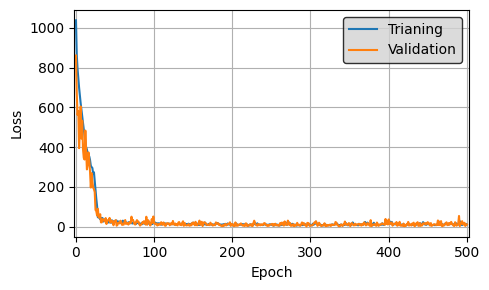

In [177]:
d = lasio.read('well1.las').df()[['CALI', 'AT10','AT30','AT60','AT90','GR','RV72H_1D_FLT','RH72H_1D_FLT']].dropna()
column_names = ['CALI', 'AT10', 'AT30', 'AT60', 'AT90', 'GR', 'Rv', 'Rh']

zstart = int(np.argwhere(d.index==9720).squeeze())
zend   = int(np.argwhere(d.index==10110).squeeze())
data = d.rename(columns=dict(zip(d.columns, column_names))).iloc[zstart:zend]
res_aniso  = data[['Rv','Rh']]

inputs         = torch.tensor(res_aniso.values, dtype=torch.float32)
dataset        = TensorDataset(inputs)
train_percent  = 0.8
xtrain, xvalid = random_split(dataset, [int(train_percent*len(dataset)), len(dataset)-int(train_percent*len(dataset))])
trainloader    = DataLoader(xtrain, batch_size=100, shuffle=True)
validloader    = DataLoader(xvalid, batch_size=100, shuffle=True)

pinn       = ResInvPINN()
criterion  = ResInvLoss(lambda_reg=1e-8)
optimizer  = torch.optim.Adam(pinn.parameters(), lr=1e-3, weight_decay=1e-8)

epochs = 501
train_loss, valid_loss = [], []
for epoch in range(epochs):
    # training
    epoch_train_loss = []
    pinn.train()
    for batch in trainloader:
        optimizer.zero_grad()
        x = batch[0]
        y = pinn(x)
        loss = criterion(x, y)
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())
    train_loss.append(np.mean(epoch_train_loss))
    # validation
    pinn.eval()
    epoch_valid_loss = []
    with torch.no_grad():
        x = next(iter(validloader))[0]
        y = pinn(x)
        loss = criterion(x, y)
        epoch_valid_loss.append(loss.item())
    valid_loss.append(np.mean(epoch_valid_loss))
    # progress
    if epoch % 100 == 0:
        print('Epoch: {} | Loss: {:.4f} | Valid Loss: {:.4f}'.format(epoch, train_loss[-1], valid_loss[-1]))

plot_loss(epochs, [train_loss, valid_loss])

Csh: min=0.008 | max=21.330


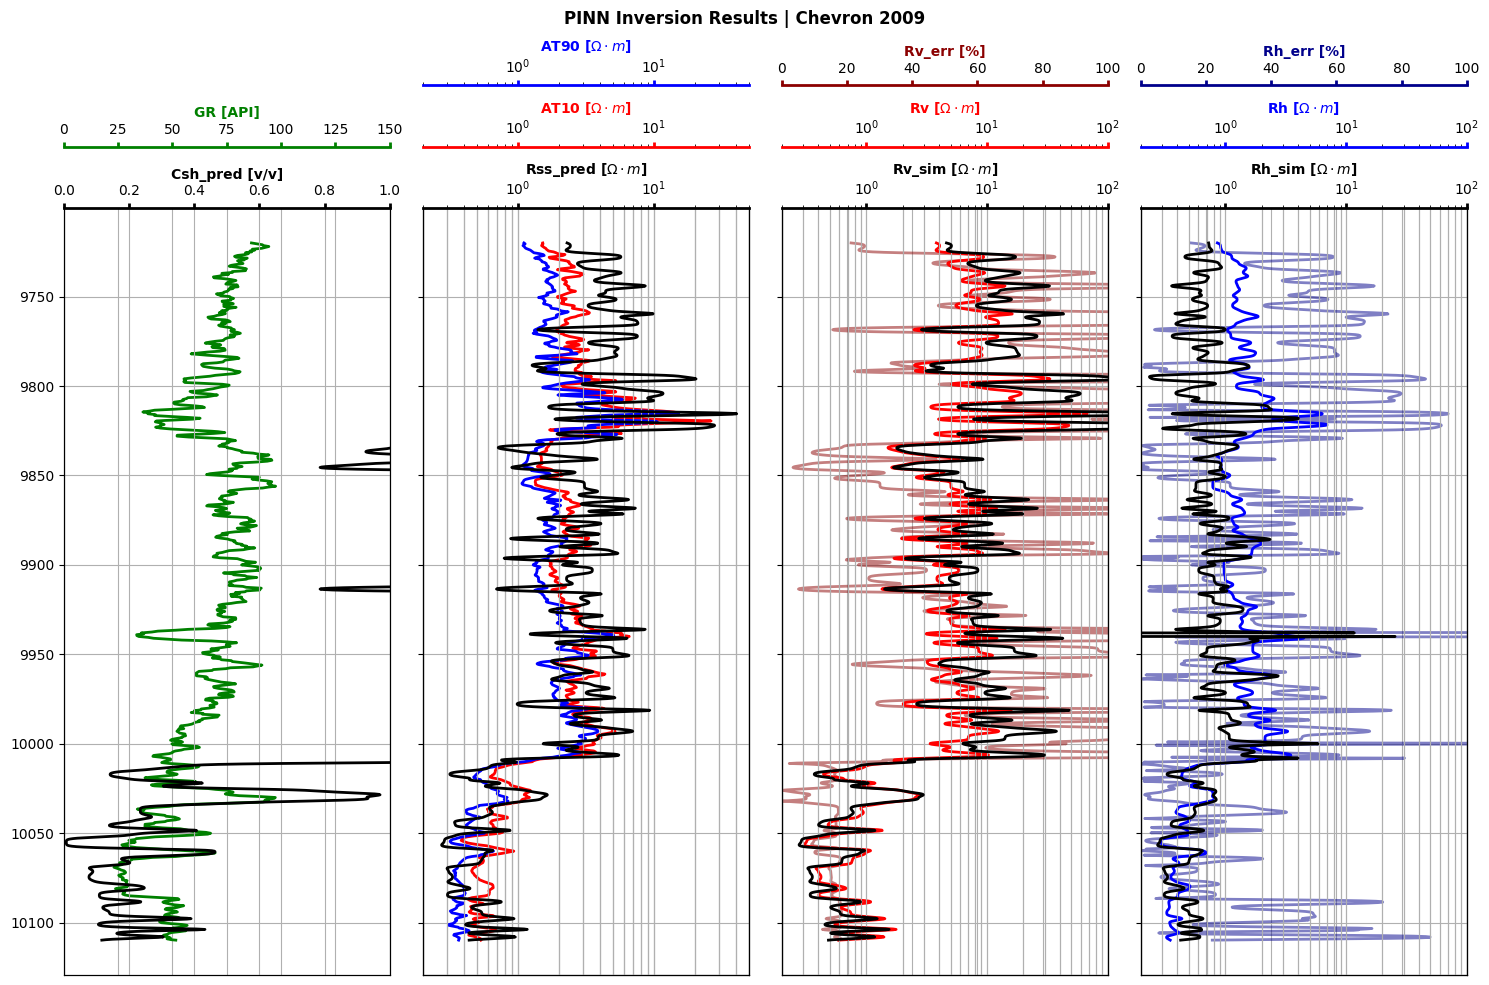

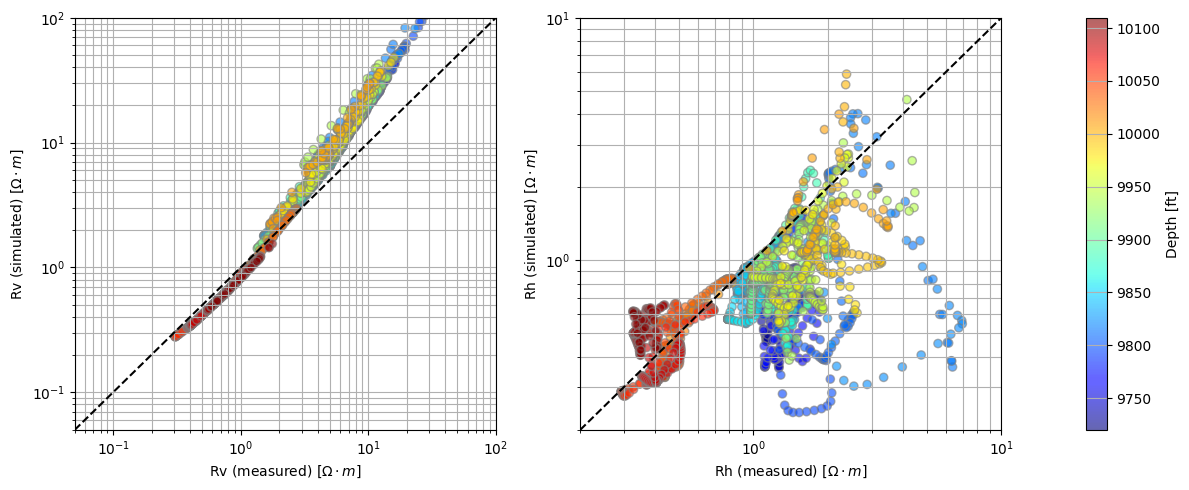

In [178]:
y_pred = pinn(inputs).detach().numpy().squeeze()
Csh_pred, Rss_pred, Rvsh_pred, Rhsh_pred = [y_pred[:, i] for i in range(y_pred.shape[1])]
print('Csh: min={:.3f} | max={:.3f}'.format(Csh_pred.min(), Csh_pred.max()))

Rv_true = res_aniso['Rv'].values
Rh_true = res_aniso['Rh'].values

Rv_sim = (Csh_pred*Rvsh_pred + (1-Csh_pred)*Rss_pred)
Rh_sim = 1/(Csh_pred/Rhsh_pred + (1-Csh_pred)/Rss_pred)

Rv_err = np.abs((Rv_sim - Rv_true)/Rv_true) * 100
Rh_err = np.abs((Rh_sim - Rh_true)/Rh_true) * 100

sol = pd.DataFrame({'Csh_pred':Csh_pred, 'Rss_pred':Rss_pred,
                    'Rv_sim':Rv_sim, 'Rh_sim':Rh_sim,
                    'Rv_err':Rv_err, 'Rh_err':Rh_err}, index=res_aniso.index)

results = pd.concat([data, sol], axis=1)

plot_pinn_results(results, subtitle='Chevron 2009')
plot_pinn_crossplot(res_aniso, (Rv_sim, Rh_sim), vlims=[0.05,100], hlims=[0.2,10], alpha=0.6)

***
# END
***

In [ ]:
def plot_inversion_solution(data, sol, ali, figsize=(16.5,10)):
    fig, axs = plt.subplots(1,5, figsize=figsize, sharey=True, width_ratios=[0.6,0.6,0.6,1,1])
    ax1, ax2, ax3, ax4, ax5 = axs
    colors = ['darkviolet','royalblue','firebrick']
    ax1.plot(data['GR'], data.index, c='g', label='GR')
    ax1.grid(True, which='both')
    ax1.set(xlim=(20,120), title='GR')
    ax1.hlines(10188.75, 0, data['GR'].max(), color='k', lw=5)
    ax2.plot(data['Rv'], data.index, c='k', label='Rv')
    ax2.plot(ali['Rv_sim'], ali['df'].iloc[1:2156,0], c='b', ls='--', label='Ali_sim')
    ax2.plot(sol['Rv_sim'], sol.index, c='r', ls='--', label='Simulated')
    ax2.set(xscale='log', title='Rv')
    ax2.grid(True, which='both')
    ax2.legend(loc='upper left', facecolor='lightgrey', edgecolor='k')
    ax2.hlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=5)
    ax3.plot(data['Rh'], data.index, c='k', label='Rh')
    ax3.plot(ali['Rh_sim'], ali['df'].iloc[1:2156,0], c='b', ls='--', label='Ali_sim')
    ax3.plot(sol['Rh_sim'], sol.index, c='r', ls='--', label='Simulated')
    ax3.set(xscale='log', title='Rh')
    ax3.grid(True, which='both')
    ax3.legend(loc='upper left', facecolor='lightgrey', edgecolor='k')
    ax3.hlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=5)
    ax4.plot(ali['Csh'], ali['df'].iloc[1:2156,0], label='Ali_1', c='b')
    ax4.plot(ali['df'].iloc[:,14], ali['df'].iloc[:,0], label='Ali_2')
    ax4.plot(sol['Csh_pred'], sol.index, label='Mine', ls='--', c='r')
    ax4.set(title='Csh', xlim=(0,1))
    ax4.legend(loc='upper left', facecolor='lightgrey', edgecolor='k')
    ax4.grid(True, which='both')
    ax4.hlines(10188.75, 0, 1, color='k', lw=5)
    ax5.plot(ali['Rss'], ali['df'].iloc[1:2156,0], label='Ali_1', c='b')
    ax5.plot(ali['df'].iloc[:,15], ali['df'].iloc[:,0], label='Ali_2')
    ax5.plot(sol['Rss_pred'], sol.index, label='Mine', ls='--', c='r')
    ax5.set(xscale='log', title='Rss'); 
    ax5.legend(loc='upper left', facecolor='lightgrey', edgecolor='k')
    ax5.grid(True, which='both')
    ax5.hlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=5)
    ax1.invert_yaxis()
    plt.tight_layout()
    plt.show()

def plot_inversion_comparison(sol, ali, figsize=(15,10)):
    fig, axs = plt.subplots(1, 6, figsize=figsize, sharey=True)
    ax1, ax2, ax3, ax4, ax5, ax6 = axs
    ax1.plot(sol['Rv'], sol.index, c='k', lw=2.75, label='Rv_true')
    ax1.plot(sol['Rv_sim'], sol.index, c='r', ls='--', label='Rv_sim')
    ax1.set(title='Rv_sim'); ax1.grid(True, which='both'); ax1.set_xscale('log')
    ax1.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')
    ax2.plot(sol['Rh'], sol.index, c='k', lw=2.75, label='Rh_true')
    ax2.plot(sol['Rh_sim'], sol.index, c='r', ls='--', label='Rh_sim')
    ax2.set(title='Rh_sim'); ax2.grid(True, which='both'); ax2.set_xscale('log')
    ax2.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')
    ax3.plot(sol['Rv'], sol.index, c='k', lw=2.75, label='Rv_true')
    ax3.plot(ali['Rv_sim'], ali['df'].iloc[:2155,0], c='b', ls='--', label='ALI_Rv_sim')
    ax3.set(title='Rv_sim'); ax3.grid(True, which='both'); ax3.set_xscale('log')
    ax3.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')
    ax4.plot(sol['Rh'], sol.index, c='k', lw=2.75, label='Rh_true')
    ax4.plot(ali['Rh_sim'], ali['df'].iloc[:2155,0], c='b', ls='--', label='ALI_Rh_sim')
    ax4.set(title='Rh_sim'); ax4.grid(True, which='both'); ax4.set_xscale('log')
    ax4.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')
    ax5.plot(sol['Rv'], sol.index, c='k', lw=2.75, label='Rv_true')
    ax5.plot(ali['Rv_sim'], ali['df'].iloc[:2155,0], c='b', ls='--', label='ALI_Rv_sim')
    ax5.plot(sol['Rv_sim'], sol.index, c='r', ls='--', label='Rv_sim')
    ax5.set(title='Rv_sim'); ax5.grid(True, which='both'); ax5.set_xscale('log')
    ax5.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')
    ax6.plot(sol['Rh'], sol.index, c='k', lw=2.75, label='Rh_true')
    ax6.plot(ali['Rh_sim'], ali['df'].iloc[:2155,0], c='b', ls='--', label='ALI_Rh_sim')
    ax6.plot(sol['Rh_sim'], sol.index, c='r', ls='--', label='Rh_sim')
    ax6.set(title='Rh_sim'); ax6.grid(True, which='both'); ax6.set_xscale('log')
    ax6.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')
    for ax in axs:
        ax.hlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=3.5)
    ax1.invert_yaxis()
    plt.tight_layout()
    plt.show()

def plot_inversion_fullsuite(data, sol, ali_sol, figsize=(17.5,10)):
    df = lasio.read('well1.las').df()
    fig, axs = plt.subplots(1, 10, figsize=(17.5,10), sharey=True)
    ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axs
    ax01, ax02 = ax0.twiny(), ax0.twiny()
    ari.plot_curve(ax0, df, 'CALI', 12, 24, 'dodgerblue', units='in', fill=True, semilog=True, pad=0)
    ari.plot_curve(ax01, df, 'GR', 10, 150, 'g', units='API', pad=8)
    ari.plot_curve(ax02, sol, 'Csh_pred', 0, 1, 'r', units='v/v', s=1, pad=16)
    ax11, ax12 = ax1.twiny(), ax1.twiny()
    ari.plot_curve(ax1, data, 'Csh_lin', 0, 1, 'k', units='v/v', pad=0)
    ari.plot_curve(ax11, data, 'Csh_q', 0, 1, 'gray', units='v/v', pad=8)
    ari.plot_curve(ax12, sol, 'Csh_pred', 0, 1, 'r', units='v/v', pad=16)
    ax21, ax22 = ax2.twiny(), ax2.twiny()
    ari.plot_curve(ax2, df, 'TNPH', 1, 0, 'b', units='PU', pad=0)
    ari.plot_curve(ax21, df, 'RHOZ', 1.65, 2.65, 'maroon', units='g/cc', pad=8)
    ari.plot_curve(ax22, df, 'PE', -5, 5, 'm', units='b/e', pad=16)
    ax31, ax32 = ax3.twiny(), ax3.twiny()
    ari.plot_curve(ax3, df, 'AT10', 0.2, 100, 'darkred', semilog=True, units='$\Omega\cdot m$', pad=0)
    ari.plot_curve(ax31, df, 'AT90', 0.2, 100, 'darkblue', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax32, sol, 'Rss_pred', 0.2, 100, 'r', semilog=True, units='$\Omega\cdot m$', pad=16)
    ax41 = ax4.twiny()
    ari.plot_curve(ax4, ali_sol, 'Csh_ALI', 0, 1, 'b', units='v/v', pad=0)
    ari.plot_curve(ax41, sol, 'Csh_pred', 0, 1, 'r', ls='--', units='v/v', pad=8)
    ax51 = ax5.twiny()
    ari.plot_curve(ax5, ali_sol, 'Rss_ALI', 0.2, 100, 'b', semilog=True, units='$\Omega\cdot m$', pad=0)
    ari.plot_curve(ax51, sol, 'Rss_pred', 0.2, 100, 'r', ls='--', semilog=True, units='$\Omega\cdot m$', pad=8)
    ax61, ax62 = ax6.twiny(), ax6.twiny()
    ari.plot_curve(ax6, df, 'RV72H_1D_FLT', 0.2, 100, 'k', s=4, semilog=True, units='$\Omega\cdot m$', pad=0)
    ari.plot_curve(ax61, ali_sol, 'Rv_sim_ALI', 0.2, 100, 'b', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax62, sol, 'Rv_sim', 0.2, 100, 'r', ls='--', semilog=True, units='$\Omega\cdot m$', pad=16)
    ax71, ax72 = ax7.twiny(), ax7.twiny()
    ari.plot_curve(ax7, df, 'RH72H_1D_FLT', 0.2, 100, 'k', s=4, semilog=True, units='$\Omega\cdot m$', pad=0)
    ari.plot_curve(ax71, ali_sol, 'Rh_sim_ALI', 0.2, 100, 'b', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax72, sol, 'Rh_sim', 0.2, 100, 'r', ls='--', semilog=True, units='$\Omega\cdot m$', pad=16)
    ax81, ax82, ax83 = ax8.twiny(), ax8.twiny(), ax8.twiny()
    ari.plot_curve(ax8, data, 'Rv', 0.2, 100, 'k', s=4, semilog=True, units='$\Omega\cdot m$', pad=0)
    ari.plot_curve(ax81, sol, 'Rv_sim', 0.2, 100, 'darkred', ls='--', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax82, data, 'Rh', 0.2, 100, 'k', s=4, semilog=True, units='$\Omega\cdot m$', pad=16)
    ari.plot_curve(ax83, sol, 'Rh_sim', 0.2, 100, 'darkblue', ls='--', semilog=True, units='$\Omega\cdot m$', pad=24)
    ax91, ax92 = ax9.twiny(), ax9.twiny()
    ari.plot_curve(ax9, sol, 'fun', 1e-6, 1e0, 'k', s=1, semilog=True, units='/', pad=0)
    ari.plot_curve(ax91, sol, 'jac_norm', 0, 2.5, 'darkmagenta', s=1, units='/', pad=8, alpha=0.5)
    ari.plot_curve(ax92, sol, 'nfev', 10, 150, 'darkgreen', s=1, units='/', pad=16, alpha=0.5)
    ax1.set_ylim(10190, 9650)
    plt.tight_layout()
    plt.show()

def plot_short_results(data, sol, figsize=(6,8), cfactor=5):
    fig, axs = plt.subplots(1, 3, figsize=figsize, sharey=True)
    ax1, ax2, ax3 = axs
    c = cfactor*(data['CALI'] - data['CALI'].mean()) / data['CALI'].std()
    ax1.plot(data['GR'], data.index, c='g', label='GR')
    ax1.plot(c, data.index, c='dodgerblue', label='CALI')
    ax2.plot(data['Rv'], data.index, c='k', label='Rv')
    ax2.plot(sol['Rv_sim'], sol.index, c='r', ls='--', label='Rv_sim')
    ax2.plot(data['Rh'], data.index, c='k', label='Rh')
    ax2.plot(sol['Rh_sim'], sol.index, c='b', ls='--', label='Rh_sim')
    ax2.set_xscale('log')
    ax3.plot(sol['Csh_pred'], sol.index, c='k', label='Csh_pred')
    for ax in axs:
        ax.grid(True, which='both')
        ax.legend(loc='upper right', facecolor='lightgrey', edgecolor='k')
    ax1.invert_yaxis()
    plt.tight_layout()
    plt.show()

***

In [ ]:
from main import *
ari = ARI()
case1, case2 = ari.load_data()

In [ ]:
ali_cg = loadmat('Ali/sol.mat', simplify_cells=True)['sol']
ali_Csh = ali_cg[0,:]
ali_Rss = ali_cg[1,:]

ali_Rvsh = 2.78
ali_Rhsh = 0.60

Rv_sim_ali = ali_Csh*ali_Rvsh + (1-ali_Csh)*ali_Rss
Rh_sim_ali = 1/(ali_Csh/ali_Rhsh + (1-ali_Csh)/ali_Rss)

ali = pd.read_csv('Ali/RVRH.csv', header=None)
d = ali.iloc[1:2156, 0].values
c = ali.iloc[1:2156, 14].values
r = ali.iloc[1:2156, 15].values
ali_sol = pd.DataFrame({'Csh_ALI':c, 'Rss_ALI':r}, index=d)
ali_sol['Rv_sim_ALI'] = c*ali_Rvsh + (1-c)*r
ali_sol['Rh_sim_ALI'] = 1/(c/ali_Rhsh + (1-c)/r)

ali_results = {'Rv_sim': Rv_sim_ali, 'Rh_sim':Rh_sim_ali, 'Csh':ali_Csh, 'Rss':ali_Rss, 'df':ali}

In [ ]:
def quadratic_inversion(df, Rvsh=None, Rhsh=None):
    quad_inv = []
    if Rvsh is None:
        Rvsh = df['Rv'].iloc[np.argmax(df['GR'])]
    if Rhsh is None:
        Rhsh = df['Rh'].iloc[np.argmax(df['GR'])]
    for _, row in df.iterrows():
        Rv, Rh = row['Rv'], row['Rh']
        a = Rh*Rvsh - Rh*Rhsh
        b = Rv**2 + Rvsh*Rhsh - 2*Rh*Rhsh
        c = Rv*Rhsh - Rh*Rhsh
        qsol = np.roots([a,b,c])
        if len(qsol) == 1:
            quad_inv.append({'Rss_q':qsol[0], 'Csh_q':np.nan})
        elif len(qsol) == 2:
            quad_inv.append({'Rss_q':qsol[0], 'Csh_q':qsol[1]})
        else:
            quad_inv.append({'Rss_q':np.nan, 'Csh_q':np.nan})
    quad_inv = pd.DataFrame(quad_inv, index=df.index)
    return quad_inv

In [ ]:
d = lasio.read('well1.las').df()[['CALI', 'AT10','AT30','AT60','AT90','GR','RV72H_1D_FLT','RH72H_1D_FLT']].dropna()
column_names = ['CALI', 'AT10', 'AT30', 'AT60', 'AT90', 'GR', 'Rv', 'Rh']

zstart = int(np.argwhere(d.index==9720).squeeze())
zend   = int(np.argwhere(d.index==10110).squeeze())
data = d.rename(columns=dict(zip(d.columns, column_names))).iloc[zstart:zend]

data['Csh_lin']  = (data['GR'] - data['GR'].min())/(data['GR'].max() - data['GR'].min())
qinv = np.abs(quadratic_inversion(data))
data = data.join(qinv)

data['Rvsh_win'] = np.nan_to_num(np.array(pd.Series(data['Rv']).rolling(250).max().tolist()), nan=data['Rv'].mean())
data['Rhsh_win'] = np.nan_to_num(np.array(pd.Series(data['Rh']).rolling(250).max().tolist()), nan=data['Rh'].mean())
R_min = np.min([data['Rh'].min(), data['Rv'].min()])
R_max = np.max([data['Rh'].max(), data['Rv'].max()])

data

In [ ]:
data['Rvsh_win'] = 2.78
data['Rhsh_win'] = 0.58
data

In [ ]:
grmax, calimax = data['GR'].max(), data['CALI'].max()
lambda_reg = 1e-5
possible_methods = ['L-BFGS-B', 'TNC', 'SLSQP', 'trust-constr']

def objective(variables, *args):
    Csh, Rs = variables   
    Rv, Rh, Rvsh, Rhsh = args[0], args[1], args[2], args[3]
    grw, caliw = args[4]/grmax, args[5]/calimax
    def loss():
        eq1 = (Csh*Rvsh + (1-Csh)*Rs) - Rv
        eq2 = (Csh/Rhsh + (1-Csh)/Rs) - (1/Rh)
        return np.expand_dims(np.array([eq1, eq2]),-1)
    def weighting(method='gr'):
        if method=='gr':
            Wd1, Wd2 = 1/Rv/grw, 1*Rh/grw
        elif method=='cali':
            Wd1, Wd2 = 1/Rv/caliw, 1*Rh/caliw
        elif method=='data':
            Wd1, Wd2 = 1/Rv, 1*Rh
        elif method=='none':
            Wd1, Wd2 = 1, 1
        else:
            raise ValueError('Invalid weighting method')
        return np.diag(np.array([Wd1, Wd2]))
    def reg(v, a=0, o=2):
        return a*linalg.norm(v, o)
    cost = np.dot(weighting(), loss())
    return linalg.norm(cost,2) + reg(variables, a=lambda_reg)

def jacobian(variables, *args):
    return Jacobian(lambda x: objective(x, *args))(variables).ravel()

def hessian(variables, *args):
    return Hessian(lambda x: objective(x, *args))(variables)

bounds = [(0,1),(R_min,R_max)]
constr = (optimize.NonlinearConstraint(lambda x: x[0], lb=bounds[0][0], ub=bounds[0][1]),
          optimize.NonlinearConstraint(lambda x: x[1], lb=bounds[1][0], ub=bounds[1][1]))

xall, xhist  = {}, []
def callback(x, *args):
    xhist.append(x)

sol = []
for i, row in data.iterrows():
    Rv_value       = row['Rv']
    Rh_value       = row['Rh']
    Csh_lin_value  = row['Csh_lin']
    GR_value       = row['GR']
    CALI_value     = row['CALI']
    Rvsh_value     = 2.813 #row['Rvsh_win'] #2.8133
    Rhsh_value     = 0.775 #row['Rhsh_win'] #0.7746

    x0 = (Csh_lin_value, np.mean([Rv_value, Rh_value]))
    c0 = (Rv_value, Rh_value, Rvsh_value, Rhsh_value, GR_value, CALI_value)
    res = optimize.minimize(objective,
                            x0          = x0,
                            args        = c0,
                            method      = 'L-BFGS-B',
                            #jac         = jacobian,
                            #hess        = hessian,
                            bounds      = bounds,
                            #constraints = constr,
                            tol         = 1e-6,
                            callback    = callback,
                            options     = {'maxiter':100},
                            )
    Csh_pred, Rss_pred = res.x
    sol.append({'Rv':Rv_value, 'Rh':Rh_value, 
                'Csh_pred':Csh_pred, 'Rss_pred':Rss_pred,
                'fun':res.fun, 'nfev':res.nfev, 'jac_norm':linalg.norm(res.jac),
                'Rv_sim':Csh_pred*Rvsh_value + (1-Csh_pred)*Rss_pred,
                'Rh_sim':1/(Csh_pred/Rhsh_value + (1-Csh_pred)/Rss_pred)})
    xall[i] = np.array([x0]+xhist)

sol = pd.DataFrame(sol, index=data.index)

In [ ]:
mse_rv = mean_squared_error(sol['Rv'], sol['Rv_sim'])
mse_rh = mean_squared_error(sol['Rh'], sol['Rh_sim'])

r2_rv = r2_score(sol['Rv'], sol['Rv_sim'])*100
r2_rh = r2_score(sol['Rh'], sol['Rh_sim'])*100

sterr_rv = np.mean(np.abs(sol['Rv']-sol['Rv_sim'])) / np.std(np.abs(sol['Rv']-sol['Rv_sim']))
sterr_rh = np.mean(np.abs(sol['Rh']-sol['Rh_sim'])) / np.std(np.abs(sol['Rh']-sol['Rh_sim']))

percerr_rv = np.mean(np.abs((sol['Rv']-sol['Rv_sim'])/sol['Rv'])) * 100
percerr_rh = np.mean(np.abs((sol['Rh']-sol['Rh_sim'])/sol['Rh'])) * 100

print('Mean Squared Error - Rv: {:.4f} | Rh: {:.4f}'.format(mse_rv, mse_rh))
print('R2 Score           - Rv: {:.3f} | Rh: {:.3f}'.format(r2_rv, r2_rh))
print('Standard Error     - Rv: {:.4f} | Rh: {:.4f}'.format(sterr_rv, sterr_rh))
print('Percentage Error   - Rv: {:.4f} | Rh: {:.4f}'.format(percerr_rv, percerr_rh))

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10,4), width_ratios=[1,1,0.1])
ax1, ax2, cax = axs

im1 = ax1.scatter(sol['Rv'], sol['Rv_sim'], c=sol.index, alpha=0.66, cmap='jet')
im2 = ax2.scatter(sol['Rh'], sol['Rh_sim'], c=sol.index, alpha=0.66, cmap='jet')

for i, ax in enumerate([ax1, ax2]):
    ax.plot([0.1,100], [0.1,100], 'k--')
    ax.set(xscale='log', yscale='log', xlabel='Measured', ylabel='Simulated',
           title=['$R_v$', '$R_h$'][i])
    ax.grid(True, which='both')
    ax.text(3, 1.25, ['R2: {:.2f}%'.format(r2_rv), 'R2: {:.2f}%'.format(r2_rh)][i],
            bbox=dict(facecolor='lightgrey', edgecolor='k', alpha=0.5))
ax1.set(xlim=(0.2,100), ylim=(0.2,100))
ax2.set(xlim=(0.25,10), ylim=(0.25,10))

cb = plt.colorbar(im1, cax=cax); cb.set_label('Depth [ft]', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

In [ ]:
plot_inversion_solution(data, sol, ali_results)
plot_inversion_comparison(sol, ali_results)
plot_inversion_fullsuite(data, sol, ali_sol)
plot_short_results(data, sol)

***
# END